Task 1. Solve classification task (7 points)

First Second name PLEASE


Napylov Ivan

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import keras
from numpy import load
import torch.nn.functional as F

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. Data preparation

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
ds = tfds.load('beans', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VFDGWS_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VFDGWS_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.VFDGWS_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [4]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
df = tfds.as_dataframe(ds)

In [6]:
df.head()

,image,label
0,"[[[149, 132, 106], [141, 124, 98], [134, 118, ...",1
1,"[[[97, 88, 57], [97, 86, 56], [105, 91, 64], [...",1
2,"[[[60, 146, 85], [61, 147, 86], [71, 153, 91],...",0
3,"[[[113, 87, 70], [112, 86, 69], [110, 84, 69],...",0
4,"[[[13, 15, 14], [15, 17, 16], [13, 15, 14], [6...",1


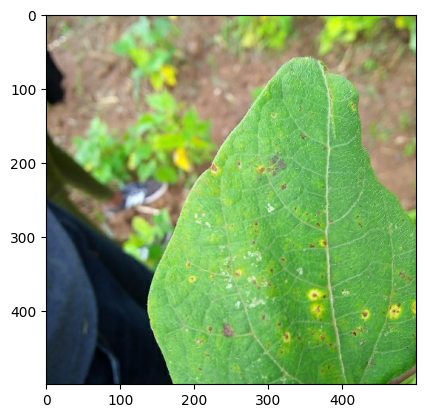

In [7]:
plt.imshow(df['image'][0], cmap='gray')

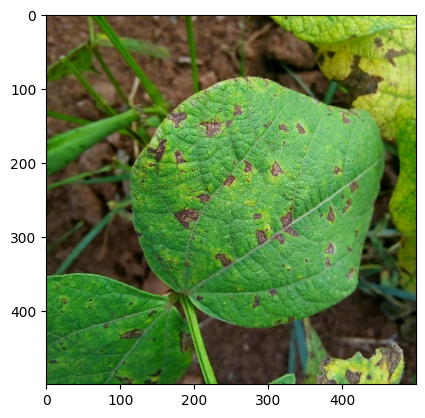

In [8]:
plt.imshow(df['image'][3], cmap='gray')

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df['image']), np.array(df['label']), test_size=0.2, random_state=10)

array([[[113,  87,  70],
        [112,  86,  69],
        [110,  84,  69],
        ...,
        [174, 210,  86],
        [165, 204,  79],
        [156, 195,  70]],

       [[108,  82,  65],
        [121,  95,  78],
        [122,  96,  81],
        ...,
        [193, 228,  98],
        [195, 232, 101],
        [192, 229,  98]],

       [[116,  91,  71],
        [110,  85,  65],
        [115,  88,  71],
        ...,
        [196, 229,  90],
        [207, 241, 102],
        [209, 243, 104]],

       ...,

       [[ 45, 115,  52],
        [ 44, 114,  51],
        [ 45, 116,  50],
        ...,
        [ 53,  76,  34],
        [ 46,  79,  22],
        [ 42,  83,  17]],

       [[ 42, 114,  50],
        [ 38, 110,  46],
        [ 39, 110,  44],
        ...,
        [ 54,  72,  32],
        [ 51,  80,  22],
        [ 48,  85,  18]],

       [[ 42, 114,  50],
        [ 38, 110,  46],
        [ 40, 111,  45],
        ...,
        [ 53,  69,  30],
        [ 52,  80,  22],
        [ 50,  85,  19]]], dtype=uint8)
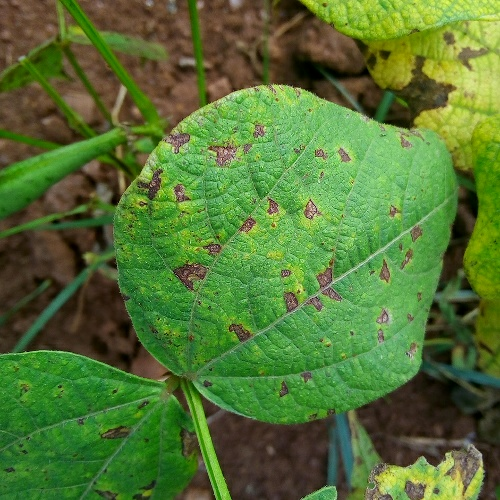

In [10]:
df['image'][3]

In [11]:
#your code here
#you can use code from lab with CNN for classification, but you will need to add extra layers. You can use any pretrained models adn data augmentation methods

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = Image.fromarray(self.data[index].astype(np.uint8))
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = MyDataset(X_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

testset = MyDataset(X_test, y_test, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

In [12]:
class MyConvNet(nn.Module):
    def __init__(self, input_size=128):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)


        self._to_linear = None
        self._compute_flattened_size(input_size)

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 3)

    def _compute_flattened_size(self, input_size):
        with torch.no_grad():
            x = torch.randn(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            print(f"Размер выхода перед Linear: {x.shape}")
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
#if torch.cuda.is_available():
#  net = MyConvNet(input_size=128).cuda()
#else:
#  net = MyConvNet(input_size=128)

#batch = []



#batch = next(iter(trainloader))
#print(batch[0].shape)

#net.forward(torch.FloatTensor(batch[0]))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MyConvNet(input_size=128).to(device)

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

Размер выхода перед Linear: torch.Size([1, 32, 29, 29])
torch.Size([16, 3, 128, 128])


In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)


train_losses = []
test_losses = []

for epoch in range(20):
    train_loss = []
    test_loss = []

    net.train()
    for i, (X_batch, y_batch) in enumerate(trainloader):
        X_batch = X_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device, dtype=torch.long)

        optimizer.zero_grad()
        y_pred = net(X_batch)

        # Размерности
        #print(f"y_pred shape: {y_pred.shape}, y_batch shape: {y_batch.shape}")

        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    net.eval()
    with torch.no_grad():
        for i, (X_test_batch, y_pred_batch) in enumerate(testloader):
            X_test_batch = X_test_batch.to(device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device, dtype=torch.long)

            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())

    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print(f"Epoch {epoch}, Train Loss: {np.mean(train_loss):.4f}, Test Loss: {np.mean(test_loss):.4f}")

Epoch 0, Train Loss: 1.0708, Test Loss: 1.0277
Epoch 1, Train Loss: 0.9883, Test Loss: 0.9068
Epoch 2, Train Loss: 0.8915, Test Loss: 0.8705
Epoch 3, Train Loss: 0.8546, Test Loss: 0.8657
Epoch 4, Train Loss: 0.8470, Test Loss: 0.8558
Epoch 5, Train Loss: 0.8216, Test Loss: 0.8502
Epoch 6, Train Loss: 0.7898, Test Loss: 0.8146
Epoch 7, Train Loss: 0.7686, Test Loss: 0.7693
Epoch 8, Train Loss: 0.7485, Test Loss: 0.7723
Epoch 9, Train Loss: 0.7241, Test Loss: 0.7644
Epoch 10, Train Loss: 0.7233, Test Loss: 0.7352
Epoch 11, Train Loss: 0.6998, Test Loss: 0.7297
Epoch 12, Train Loss: 0.6812, Test Loss: 0.7359
Epoch 13, Train Loss: 0.6726, Test Loss: 0.7641
Epoch 14, Train Loss: 0.6650, Test Loss: 0.7130
Epoch 15, Train Loss: 0.6505, Test Loss: 0.7935
Epoch 16, Train Loss: 0.6698, Test Loss: 0.6757
Epoch 17, Train Loss: 0.6497, Test Loss: 0.7173
Epoch 18, Train Loss: 0.6388, Test Loss: 0.7080
Epoch 19, Train Loss: 0.6173, Test Loss: 0.6842


Baseline accuracy more than 70 for all of classes AND more than 35 for each class
<br>**Please Note** each 1 missing from accuracy (for all or for each) will be evaluated as -0.5 from total grade

In [16]:
from sklearn.metrics import accuracy_score

net.eval()
y_true, y_pred_list = [], []

with torch.no_grad():
    for X_test_batch, y_test_batch in testloader:
        X_test_batch = X_test_batch.to(device, dtype=torch.float32)
        y_test_batch = y_test_batch.to(device, dtype=torch.long)

        y_test_pred = net(X_test_batch)
        y_pred_labels = torch.argmax(y_test_pred, dim=1)  # Предсказанные метки

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred_list.extend(y_pred_labels.cpu().numpy())

# Вычисляем точность
acc = accuracy_score(y_true, y_pred_list)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 69.57%


In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred_list))
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_list))

[[42 17  6]
 [13 51 15]
 [ 5  7 51]]
              precision    recall  f1-score   support

           0       0.70      0.65      0.67        65
           1       0.68      0.65      0.66        79
           2       0.71      0.81      0.76        63

    accuracy                           0.70       207
   macro avg       0.70      0.70      0.70       207
weighted avg       0.69      0.70      0.69       207



Write a function for classification of one image (3 points):
<br> Input: 1 image from dataset
<br> Output: predicted class, target class and comparison

In [18]:
def classify_one_image(model, dataset, device, class_names):
    model.eval()


    index = np.random.randint(0, len(dataset))
    image, target = dataset[index]


    image_tensor = image.unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5


    plt.imshow(image_np)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted_class]} | Actual: {class_names[target]}")
    plt.show()

    return {"Predicted Class": class_names[predicted_class], "Target Class": class_names[target]}

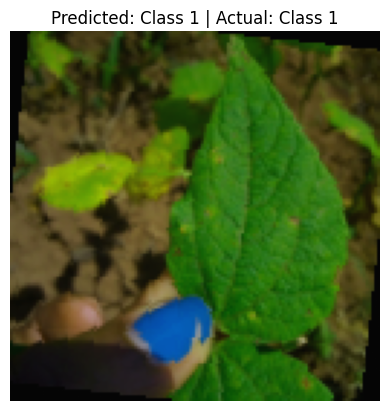

{'Predicted Class': 'Class 1', 'Target Class': 'Class 1'}

In [22]:
class_names = ["Class 0", "Class 1", "Class 2"]
classify_one_image(net, testset, device, class_names)

Theoretical part (5 points)
<br> 1) Describe the reason of the use data augmentation
<br> 2) Provide example of metrics for solving classification, segmentation and object detection problem

Data augmentation is used in deep learning to artificially expand the training dataset by applying transformations such as rotation, flipping, cropping, scaling, color adjustments, and noise addition. The main reasons for using data augmentation are:

Improves Model Generalization: Helps prevent overfitting by making the model robust to variations in the data.
Increases Dataset Size: Useful when there is limited labeled data, making the model more effective.
Handles Class Imbalance: Augmenting underrepresented classes can balance the dataset.
Improves Model Robustness: Enhances the model’s ability to recognize patterns under different conditions (e.g., lighting changes, occlusions).

Classification:
Classification tasks involve predicting discrete labels for input data. Common metrics include:

Accuracy: The ratio of correctly predicted instances to the total number of instances.

Precision: The ratio of correctly predicted positive instances to the total predicted positives.

Recall (Sensitivity): The ratio of correctly predicted positive instances to the total actual positives.

F1-Score: The harmonic mean of precision and recall.

Confusion Matrix: A table showing true positives, false positives, true negatives, and false negatives.

Segmentation:
Segmentation tasks involve assigning a label to each pixel in an image. Common metrics include:

Intersection over Union (IoU): The ratio of the overlap between the predicted and ground truth segmentation to the union of the two.

Dice Coefficient (F1-Score for Segmentation): Measures the overlap between the predicted and ground truth masks.

